In [12]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.sparse import diags
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_context("paper")
sns.set_style("ticks")

In [13]:
def obs_operator(l_obs, l, boundary = (0, np.pi)):
    """
    returns observation operator

    Input: l_obs - controls number of observation points
    l - controls the PDE discretization
    boundary - describes boundary points of interval I (domain of PDE)

    Output: O - array of shape (n_obs, n)
    For coefficient vector p, O @ p contains the values of the corresponding function at n_obs aequidistant points of the inteval I
    """

    # n_obs - number of observation points
    # n - number of discretization points
    n_obs = 2 ** l_obs - 1
    n = 2 ** l - 1

    O = np.zeros((n_obs, n))

    # If there are more discretization points than observation points, choose aequidistant discretization points as observation points
    if n >= n_obs:
        for k in range(n_obs):
            O[k, (k + 1) * 2 ** (l - l_obs) - 1] = 1
    # If there are more observation points, calculate the entries of the operator using linear hat functions
    else:
        domain_width = boundary[1] - boundary[0]
        h_FE = domain_width / 2 ** l
        h_observation = domain_width / 2 ** l_obs
        for k in range(n_obs):
            for l in range(n):
                x = boundary[0] + h_observation * k
                x_1 = boundary[0] + h_FE * l
                O[k, l] = linear_hat_fct(x, x_1, h_FE)

    return O

def linear_hat_fct(x, x_1, h):
    if abs(x - x_1) <= h:
        return 1 - (abs(x - x_1) / h)
    else:
        return 0.0
    
def random_laplacian(n_dim, n):
    """
    draws sample of KL expansion

    Input: n_dim - truncation of KL expansion
    n - number of inner discretization points

    Output: u - array containing function values of the realization on n aequidistant discretization points
    """
    # h - mesh width/distance between discretization points
    # x - array of inner discretization points
    h = 1 / (n + 1)
    x = np.linspace(h, 1 - h, n)

    # D - array of shape (n_dim, n_dim) containing constant factors sqrt(2h)/(pi*k) on diagonal
    diagonal = np.sqrt(2 * h) / (np.pi * np.arange(1, n_dim + 1))
    D = np.diag(diagonal)

    # Q array of shape (n_dim, n) containing sinus terms evaluated at x
    Q = np.array([np.sin(j * np.pi * x) for j in range(1, n_dim + 1)])

    # Draw samples according to the standard normal distribution (the variance h is already incorporated in D)
    rv = multivariate_normal.rvs(mean=0, cov=1, size=n_dim)
    rv = np.asarray(rv).flatten()

    u = Q.T @ D @ rv
    return u

def random_laplacian_operator(n_dim, n):
    """
    computes covariance of KL expansion

    Input: n_dim - truncation of KL expansion
    n - number of inner discretization points

    Output: C - covariance array
    """
    # h - mesh width/distance between discretization points
    # x - array of inner discretization points
    h = 1 / (n + 1)
    x = np.linspace(h, 1 - h, n)

    # D - array of shape (n_dim, n_dim) containing constant factors 2h/(pi*k)^2 on diagonal
    diagonal = 2 * h / (np.pi * np.arange(1, n_dim + 1)) ** 2
    D_squared = np.diag(diagonal)

    # Q array of shape (n_dim, n) containing sinus terms evaluated at x
    Q = np.array([np.sin(j * np.pi * x) for j in range(1, n_dim + 1)])

    C = Q.T @ D_squared @ Q
    return C

def solve_forward_nonlinear(u):
    """
    solves PDE for f(x)=100x with finite element method

    Input: u - unknown parameter/real factor on right hand side of the PDE

    Output: p - solution to discretized PDE
    """

    # n - number of inner discretization points
    # h - mesh width/distance between discretization points
    n = u.size
    h = 1 / (n + 1)

    # rhs - right hand side of linear system
    f = lambda x: 100 * x
    rhs = np.array([f(k * h) * h for k in range(1, n + 1)])

    # Compute stiffness matrix
    co = np.concatenate(([0], np.exp(u), [0]))

    diagonal = (co[:n] + 2 * co[1:n + 1] + co[2:n + 2])
    adjacent_diagonal = - (co[1:n] + co[2:n + 1])

    stiffness_matrix = diags([adjacent_diagonal,
               diagonal,
               adjacent_diagonal],
              [-1, 0, 1]).toarray()
    stiffness_matrix = stiffness_matrix / (2 * h)

    # Solve linear system
    p = np.linalg.solve(stiffness_matrix, rhs)
    return p

def unc_to_obs_nonlinear(u, l_obs, l):
    """
    computes observation for nonlinear PDE for given realisation u

    Input: u - unknown parameter
    l_obs - controls number of observation points
    l - controls the PDE discretization

    Output: observation array
    """
    assert u.shape[0] == 2 ** l - 1, "Discretization of u does not match given level"

    Op = obs_operator(l_obs, l, (0,1))
    p = solve_forward_nonlinear(u)

    return Op @ p

### Getting a feel for the $u$ and the $G(u)$

G(u) = [6.38842503]


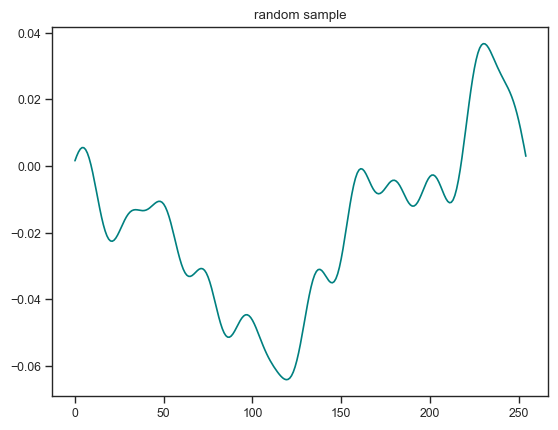

In [14]:
# Set dimension of KL expansion, observation and discretization level
n_dim = 25
l_obs = 1
l = 8
n = 2 ** l - 1

# Draw sample
u = random_laplacian(n_dim, n)
plt.plot(u, color="teal")
plt.title(f"random sample")
#plt.legend()

# Compute observation
Gu = unc_to_obs_nonlinear(u, l_obs, l)
print(f"G(u) = {Gu}")

### Generating samples via *ALDI* and true noise level

Dimension of the initial ensemble: (63, 100)
Dimension of the observation: (15,)
Generating samples with 750 ALDI-iterations...


ALDI: 100%|██████████| 750/750 [00:21<00:00, 34.59it/s]


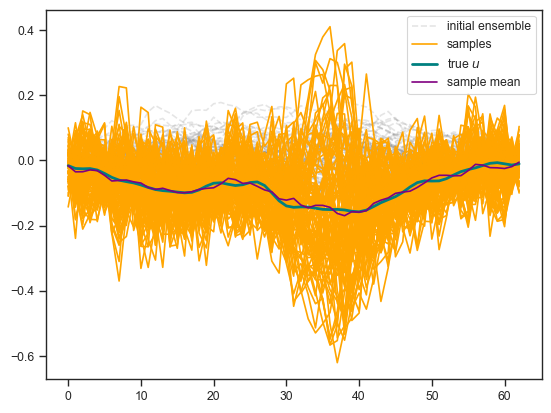

In [15]:
# Set dimension of KL expansion and discretization level
n_dim_truth = 25
l_obs = 4
l = 6
n = 2 ** l - 1

# Draw sample
u_truth = random_laplacian(n_dim_truth, n)

# Noisy observation
noise_mean = 0
noise_level = 0.01 ** 2
noise = multivariate_normal.rvs(mean=noise_mean, cov=noise_level)

y = unc_to_obs_nonlinear(u_truth, l_obs, l) + noise
G = lambda u: unc_to_obs_nonlinear(u, l_obs, l).T

n_dim = 50

# Prior setup
mean_prior = np.zeros(n)
cov_prior = random_laplacian_operator(n_dim, n)

n_samples = 100

initial_ensemble = np.array([random_laplacian(n_dim, n) for i in range(n_samples)]).T
print(f"Dimension of the initial ensemble: {initial_ensemble.shape}")
print(f"Dimension of the observation: {y.shape}")
#_ = [plt.plot(G(initial_ensemble[:,i]), color="grey", alpha=.5) for i in range(n_samples)]
#plt.show()

from potential import Potential

potential = Potential(forward_map=G,
                      dimensions=(n, 2 ** l_obs - 1),
                      prior_mean=mean_prior,
                      prior_sigma=cov_prior,
                      observation=y)
potential.set_error_sigma(noise_level)

from aldi import ALDI

n_iter = 750

sampler = ALDI(step_size=0.001, 
               number_of_iterations=n_iter,
               gradient_free=True,
               ensemble=initial_ensemble,
               potential=potential,
               verbose=True)

print(f"Generating samples with {n_iter} ALDI-iterations...")

samples = sampler.generate_samples()

_ = [plt.plot(initial_ensemble[:, i], label="initial ensemble" if i==0 else None, color="grey", alpha=.2, linestyle="dashed") for i in range(n_samples)]
_ = [plt.plot(samples[:, i], label="samples" if i==0 else None, color="orange") for i in range(n_samples)]
plt.plot(u_truth, label=r"true $u$", color="teal", linewidth=2.)
plt.plot(np.mean(samples, axis=1), color="purple", label="sample mean")
plt.legend()

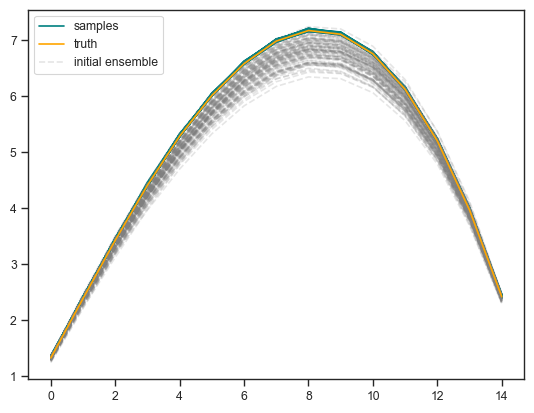

In [16]:

_ = [plt.plot(G(samples[:,i]), color="teal", label="samples" if i==0 else None) for i in range(n_samples)]
plt.plot(G(u_truth), color="orange", label="truth", zorder=3)
_ = [plt.plot(G(initial_ensemble[:,i]), color="grey", alpha=.2, label="initial ensemble" if i==0 else None, linestyle="dashed") for i in range(n_samples)]

plt.legend()

In [17]:
from langevem import LEM
from tqdm import tqdm

# Set dimension of KL expansion and discretization level
n_dim_truth = 5
l_obs = 6
l = 4
n = 2 ** l - 1
n_obs = 2 ** l_obs - 1

# Draw sample
u_truth = random_laplacian(n_dim_truth, n)
print(u_truth.shape)

# Noisy observation
noise_mean = np.zeros(n_obs)
noise_level = 0.01**2
noise = multivariate_normal.rvs(mean=noise_mean, cov=noise_level*np.eye(n_obs))

y = np.expand_dims(unc_to_obs_nonlinear(u_truth, l_obs, l) + noise, axis=0)
print(y.shape)
G = lambda u: unc_to_obs_nonlinear(u, l_obs, l)

n_dim = 10

# Prior setup
mean_prior = np.zeros(n)
cov_prior = random_laplacian_operator(n_dim, n)
n_samples = 50

n_runs = 1
n_iter = 10
noise_estimates = np.zeros((n_runs, n_iter))
for i in tqdm(range(n_runs)):
    lem = LEM(observations=y,
            samples_per_observation=n_samples,
            forward_map=G,
            forward_gradient=None,
            prior_mean=mean_prior,
            prior_covariance=cov_prior,
            number_of_iterations=n_iter,
            initial_noise_estimate=.1,
            dimensions=(n, n_obs),
            sampler_steps=100,
            gradient_free=True,
            verbose=True)
    lem.max_step_size = 0.001

    initial_ensemble = np.array([random_laplacian(n_dim, n) for i in range(n_samples)]).T
    lem.ensembles = initial_ensemble.copy()
    ensemble, noise_estimates[i, :] = lem.EM(return_archive=True)

(15,)
(1, 63)


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 1...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 25.61it/s]


Updating noise estimate...
Current noise estimate: 0.011458383872368338
Iteration 2...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


Updating noise estimate...
Current noise estimate: 0.002566559950512253
Iteration 3...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Updating noise estimate...
Current noise estimate: 0.0006796778070953298
Iteration 4...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 25.54it/s]


Updating noise estimate...
Current noise estimate: 0.00020072447659386975
Iteration 5...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


Updating noise estimate...
Current noise estimate: 0.00010779273092139337
Iteration 6...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Updating noise estimate...
Current noise estimate: 9.226746304955817e-05
Iteration 7...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 26.25it/s]


Updating noise estimate...
Current noise estimate: 9.151719815185125e-05
Iteration 8...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Updating noise estimate...
Current noise estimate: 9.113756059887962e-05
Iteration 9...      
Generating samples...


ALDI: 100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


Updating noise estimate...
Current noise estimate: 9.080126122880967e-05
Iteration 10...     
Generating samples...


100%|██████████| 1/1 [00:38<00:00, 38.14s/it]

Updating noise estimate...
Current noise estimate: 9.045038716448093e-05


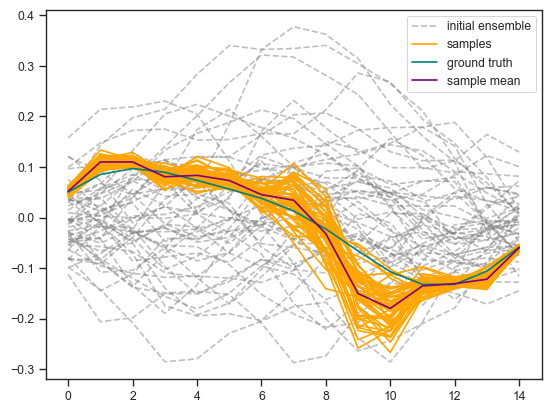

In [18]:
_ = [plt.plot(initial_ensemble[:,i], label="initial ensemble" if i==0 else None, color="grey", alpha=.5, linestyle="dashed") for i in range(n_samples)]
_ = [plt.plot(ensemble[:,i], label="samples" if i==0 else None, color="orange") for i in range(n_samples)]
plt.plot(u_truth, label="ground truth", color="teal")
plt.plot(np.mean(ensemble, axis=1), color="purple", label="sample mean")
plt.legend()

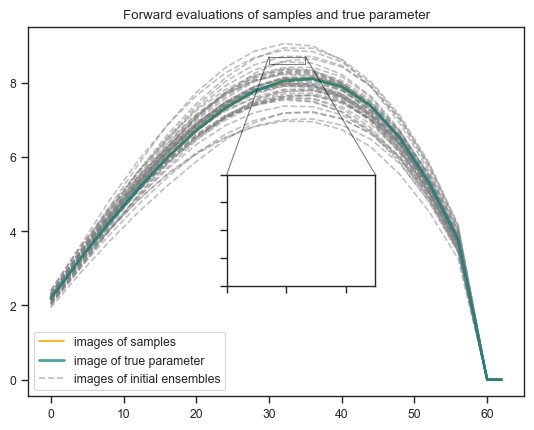

In [19]:
fig, ax = plt.subplots()

_ = [ax.plot(G(ensemble[:,i]), color="orange", label="images of samples" if i==0 else None) for i in range(n_samples)]
ax.plot(G(u_truth), color="teal", label="image of true parameter", linewidth=2., zorder=3, alpha=.7)
_ = [ax.plot(G(initial_ensemble[:,i]), color="grey", alpha=.5, linestyle="dashed", label="images of initial ensembles" if i==0 else None) for i in range(n_samples)]

x1, x2, y1, y2 = 30, 35, 8.5, 8.7  # subregion of the original image
axins = ax.inset_axes([.4, .3, .3, .3], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
_ = [axins.plot(G(ensemble[:,i]), color="orange", label="samples" if i==0 else None) for i in range(n_samples)]
axins.plot(G(u_truth), color="teal", label=r"$u^*$", linewidth=2., zorder=3, alpha=.7)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.title("Forward evaluations of samples and true parameter")

plt.legend()

Relative noise level approximation error $\frac{|\tilde{\sigma}^2 - \sigma^2|}{\sigma^2}$ for $l=6$ and $l_\text{obs} = 6$.

Final mean relative error: 9.55%


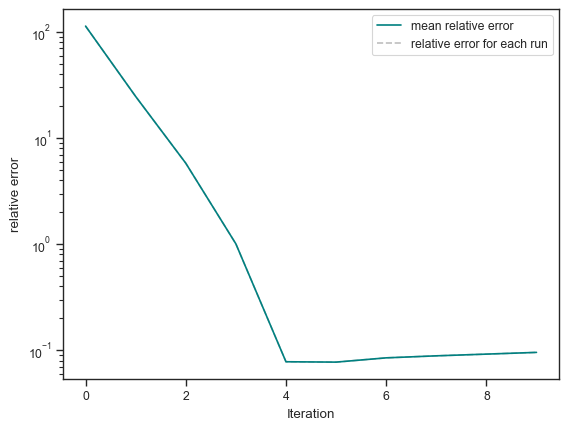

In [20]:
mean_errors = np.abs(np.mean(noise_estimates, axis=0) - noise_level)
mean_relative_errors = mean_errors/noise_level

plt.plot(mean_relative_errors, label="mean relative error", color="teal", zorder=3)
_ = [plt.plot(np.abs(noise_estimates[i, :] - noise_level)/noise_level, color="grey", linestyle="dashed", alpha=.5, label="relative error for each run" if i==0 else None) for i in range(n_runs)]
plt.legend()
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("relative error")
print(f"Final mean relative error: {mean_relative_errors[-1]:.2%}")

### Investigating the effect of the number of observation points

In [21]:
n_dim_truth = 5
list_obs = [4, 5, 6, 7]
l = 6
n = 2 ** l - 1


# Draw sample
u_truth = random_laplacian(n_dim_truth, n)
print(u_truth.shape)

# Noisy observation
noise_level = 0.01**2


n_dim = 10

# Prior setup
mean_prior = np.zeros(n)
cov_prior = random_laplacian_operator(n_dim, n)
n_samples = 50
initial_ensemble = np.array([random_laplacian(n_dim, n) for i in range(n_samples)]).T

n_runs = 1
n_iter = 10
noise_estimates = np.zeros((n_runs, len(list_obs)))

for i, l_obs in enumerate(list_obs):
    n_obs = 2 ** l_obs - 1
    noise_mean = np.zeros(n_obs)
    noise = multivariate_normal.rvs(mean=noise_mean, cov=noise_level*np.eye(n_obs))
    y = np.expand_dims(unc_to_obs_nonlinear(u_truth, l_obs, l) + noise, axis=0)
    G = lambda u: unc_to_obs_nonlinear(u, l_obs, l)

    for run in tqdm(range(n_runs)):
        lem = LEM(observations=y,
                samples_per_observation=n_samples,
                forward_map=G,
                forward_gradient=None,
                prior_mean=mean_prior,
                prior_covariance=cov_prior,
                number_of_iterations=n_iter,
                initial_noise_estimate=0.1,
                dimensions=(n, n_obs),
                sampler_steps=300,
                gradient_free=True,
                verbose=False)

        lem.ensembles = initial_ensemble.copy()
        lem.max_step_size = 0.001
        lem.noise_estimate = 0.1
        print(f"Run #{run}: Generating samples and estimating noise for observational level {l_obs}.")
        ensemble, noise_estimates[run, i] = lem.EM(return_archive=False)
        print(f"Final noise estimate: {noise_estimates[run, i]}")

(63,)


  0%|          | 0/1 [00:00<?, ?it/s]

Run #0: Generating samples and estimating noise for observational level 4.


100%|██████████| 1/1 [00:42<00:00, 42.81s/it]


Final noise estimate: 0.1


  0%|          | 0/1 [00:00<?, ?it/s]

Run #0: Generating samples and estimating noise for observational level 5.


100%|██████████| 1/1 [00:42<00:00, 42.31s/it]


Final noise estimate: 0.013899455487655341


  0%|          | 0/1 [00:00<?, ?it/s]

Run #0: Generating samples and estimating noise for observational level 6.


100%|██████████| 1/1 [00:43<00:00, 43.08s/it]


Final noise estimate: 0.00010336787631845301


  0%|          | 0/1 [00:00<?, ?it/s]

Run #0: Generating samples and estimating noise for observational level 7.


100%|██████████| 1/1 [10:10<00:00, 610.95s/it]

Final noise estimate: 9.876403912359506e-05


Relative noise level approximation error $\frac{|\tilde{\sigma}^2 - \sigma^2|}{\sigma^2}$ for $l=6$ and $l_\text{obs} \in \{2,3,4,5,6\}$.

Final relative error 1.236%
Final absolute error 0.00000


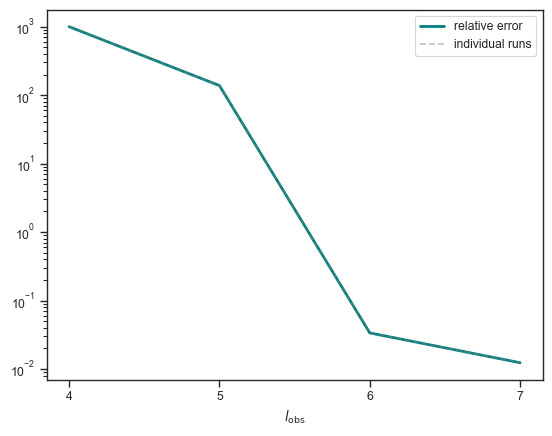

In [24]:
sns.set_context("paper")

estimates = noise_estimates[:, :]

plt.plot(list_obs, np.abs(np.mean(estimates, axis=0) - noise_level)/noise_level, color="teal", linewidth=2., label="relative error")
_ = [plt.plot(list_obs, np.abs(estimates[i,:] - noise_level)/noise_level, color="grey", alpha=.5, linestyle="dashed", label="individual runs" if i==0 else None) for i in range(n_runs)]
plt.xlabel(r"$l_\text{obs}$")
plt.xticks(list_obs)
plt.yscale("log")
plt.legend()
print(f"Final relative error {(np.abs(np.mean(estimates, axis=0) - noise_level)/noise_level)[-1]:.3%}")
print(f"Final absolute error {(np.abs(np.mean(estimates, axis=0) - noise_level))[-1]:.5f}")

## Adaptive ALDI-timesteps


In [27]:
from timeit import default_timer as timer

n_dim_truth = 5
l_obs = 6
l = 4
n = 2 ** l - 1
n_obs = 2 ** l_obs - 1

# Draw sample
u_truth = random_laplacian(n_dim_truth, n)

# Noisy observation
noise_mean = np.zeros(n_obs)
noise_level = 0.01**2
noise = multivariate_normal.rvs(mean=noise_mean, cov=noise_level*np.eye(n_obs))

n_dim = 10

y = np.expand_dims(unc_to_obs_nonlinear(u_truth, l_obs, l) + noise, axis=0)
G = lambda u: unc_to_obs_nonlinear(u, l_obs, l)

# Prior setup
mean_prior = np.zeros(n)
cov_prior = random_laplacian_operator(n_dim, n)
n_samples = 50
initial_ensemble = np.array([random_laplacian(n_dim, n) for i in range(n_samples)]).T

step_numbers = [25, 50, 75, 100, 200, 300]
step_sizes = [0.1, 0.015, 0.01, 0.0015, 0.001, 0.00015]

n_runs = 3
n_iter = 2
noise_estimates = np.zeros((n_runs, n_iter * len(step_numbers)))
noise_estimates_comp = np.zeros((n_runs, n_iter * len(step_numbers)))

time_steps = np.zeros((n_runs))
time_comp = np.zeros((n_runs))

for run in range(n_runs):
    noise = 0.1
    print(f"\n###### RUN {run+1} ######\n")
    t_start = timer()
    for i, steps in enumerate(step_numbers):
        ensemble = initial_ensemble.copy()
        lem = LEM(observations=y,
                samples_per_observation=n_samples,
                forward_map=G,
                forward_gradient=None,
                prior_mean=mean_prior,
                prior_covariance=cov_prior,
                number_of_iterations=n_iter,
                initial_noise_estimate=0.01,
                dimensions=(n, 2**l_obs-1),
                sampler_steps=steps,
                gradient_free=True,
                verbose=False)

        lem.ensembles = ensemble
        lem.noise_estimate = noise
        lem.max_step_size = step_sizes[i]
        print(f"Generating samples and estimating noise with {steps} ALDI-steps.")
        ensemble, noise_estimate = lem.EM(return_archive=True)
        noise_estimates[run, n_iter * i:n_iter * i + n_iter] = noise_estimate
        noise = noise_estimate[-1]
        print(f"Final noise estimate: {noise:.4E}")
    t_end = timer()
    time_steps[run] = t_end-t_start
    print(f"Execution took {time_steps[run]:.3f} seconds.")

    print(f"Performing a comparison run with fixed steps.")
    t_start = timer()
    lem_comp = LEM(observations=y,
            samples_per_observation=n_samples,
            forward_map=G,
            forward_gradient=None,
            prior_mean=mean_prior,
            prior_covariance=cov_prior,
            number_of_iterations=n_iter*len(step_sizes),
            initial_noise_estimate=0.1,
            dimensions=(n, 2**l_obs-1),
            sampler_steps=step_numbers[-1],
            gradient_free=True,
            verbose=False)

    lem_comp.ensembles = initial_ensemble.copy()
    lem_comp.max_step_size = step_sizes[-3]
    ensemble, noise_estimates_comp[run, :] = lem_comp.EM(return_archive=True)
    t_end = timer()
    time_comp[run] = t_end-t_start
    print(f"Final noise estimate: {noise_estimates_comp[run, -1]:.4E}")
    print(f"Execution took {time_comp[run]:.3f} seconds.")
    


###### RUN 1 ######

Generating samples and estimating noise with 25 ALDI-steps.


ALDI: 100%|██████████| 25/25 [00:00<00:00, 27.25it/s]


Final noise estimate: 1.0000E-01
Generating samples and estimating noise with 50 ALDI-steps.


ALDI: 100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


Final noise estimate: 9.3513E-03
Generating samples and estimating noise with 75 ALDI-steps.


ALDI: 100%|██████████| 75/75 [00:02<00:00, 29.13it/s]


Final noise estimate: 3.5314E-04
Generating samples and estimating noise with 100 ALDI-steps.


ALDI: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Final noise estimate: 1.0621E-04
Generating samples and estimating noise with 200 ALDI-steps.


ALDI: 100%|██████████| 200/200 [00:07<00:00, 28.12it/s]


Final noise estimate: 9.6395E-05
Generating samples and estimating noise with 300 ALDI-steps.


ALDI: 100%|██████████| 300/300 [00:10<00:00, 28.18it/s]


Final noise estimate: 9.6385E-05
Execution took 53.632 seconds.
Performing a comparison run with fixed steps.


ALDI: 100%|██████████| 300/300 [00:10<00:00, 29.02it/s]


Final noise estimate: 1.0683E-04
Execution took 126.468 seconds.

###### RUN 2 ######

Generating samples and estimating noise with 25 ALDI-steps.


ALDI: 100%|██████████| 25/25 [00:00<00:00, 29.00it/s]


Final noise estimate: 1.0000E-01
Generating samples and estimating noise with 50 ALDI-steps.


ALDI: 100%|██████████| 50/50 [00:01<00:00, 29.07it/s]


Final noise estimate: 9.5869E-03
Generating samples and estimating noise with 75 ALDI-steps.


ALDI: 100%|██████████| 75/75 [00:02<00:00, 28.43it/s]


Final noise estimate: 3.1023E-04
Generating samples and estimating noise with 100 ALDI-steps.


ALDI: 100%|██████████| 100/100 [00:03<00:00, 29.20it/s]


Final noise estimate: 1.0725E-04
Generating samples and estimating noise with 200 ALDI-steps.


ALDI: 100%|██████████| 200/200 [00:06<00:00, 29.17it/s]


Final noise estimate: 9.8359E-05
Generating samples and estimating noise with 300 ALDI-steps.


ALDI: 100%|██████████| 300/300 [00:10<00:00, 28.35it/s]


Final noise estimate: 9.7507E-05
Execution took 52.659 seconds.
Performing a comparison run with fixed steps.


ALDI: 100%|██████████| 300/300 [00:11<00:00, 26.11it/s]


Final noise estimate: 1.0783E-04
Execution took 130.086 seconds.

###### RUN 3 ######

Generating samples and estimating noise with 25 ALDI-steps.


ALDI: 100%|██████████| 25/25 [00:00<00:00, 28.30it/s]


Final noise estimate: 9.5943E-03
Generating samples and estimating noise with 50 ALDI-steps.


ALDI: 100%|██████████| 50/50 [00:01<00:00, 28.45it/s]


Final noise estimate: 5.8940E-04
Generating samples and estimating noise with 75 ALDI-steps.


ALDI: 100%|██████████| 75/75 [00:02<00:00, 28.03it/s]


Final noise estimate: 1.2007E-04
Generating samples and estimating noise with 100 ALDI-steps.


ALDI: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Final noise estimate: 9.8818E-05
Generating samples and estimating noise with 200 ALDI-steps.


ALDI: 100%|██████████| 200/200 [00:06<00:00, 28.68it/s]


Final noise estimate: 9.5749E-05
Generating samples and estimating noise with 300 ALDI-steps.


ALDI: 100%|██████████| 300/300 [00:10<00:00, 29.18it/s]


Final noise estimate: 9.8164E-05
Execution took 52.661 seconds.
Performing a comparison run with fixed steps.


ALDI: 100%|██████████| 300/300 [00:10<00:00, 27.31it/s]

Final noise estimate: 1.0901E-04
Execution took 132.191 seconds.


Text(0.5, 1.0, 'Mean execution time (minutes)')

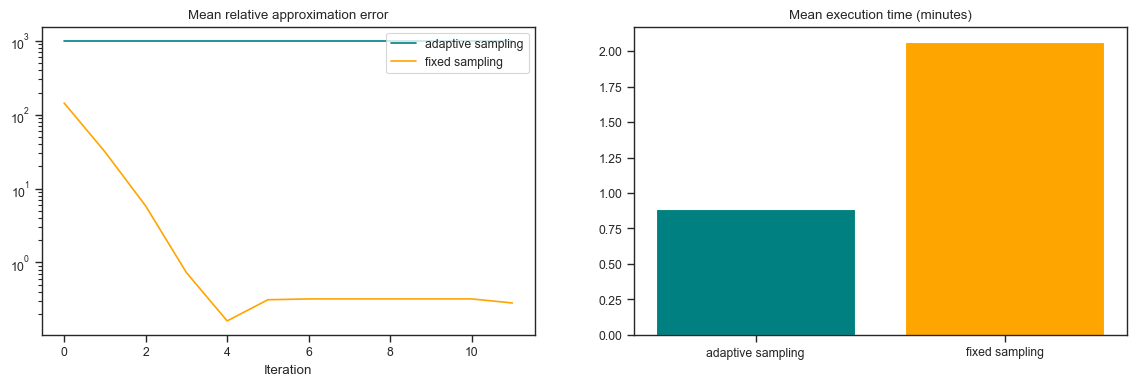

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].plot(np.abs(np.mean(noise_estimates, axis=0)-noise_level)/noise_level, c="teal", label="adaptive sampling")
#_ = [axs[0].plot(np.abs(noise_archive_steps[i, :]-error_sigma)/error_sigma, c="grey", label=None, alpha=.2, linestyle="dashed") for i in range(n_runs)]
#axs[0].scatter([2, 4, 6, 8, 10], np.abs(np.mean(noise_archive_steps[:,[2, 4, 6, 8, 10]], axis=0)-error_sigma)/error_sigma, edgecolors="grey", facecolors="none", s=200, alpha=.5, label="sample step increase")
axs[0].plot(np.abs(np.mean(noise_estimates_comp, axis=0)-noise_level)/noise_level, c="orange", label="fixed sampling")
axs[0].set_xlabel("Iteration")
axs[0].set_title("Mean relative approximation error")
axs[0].set_yscale("log")
axs[0].set_xticks([n_iter*i for i in range(len(step_numbers))])
axs[0].legend(loc=1)
#axs[0].set_xscale("log")

axs[1].bar(["adaptive sampling", "fixed sampling"], (np.mean(time_steps)/60, np.mean(time_comp)/60), color=["teal", "orange"])
axs[1].set_title("Mean execution time (minutes)")